In [1]:
import numpy as np
import scipy.special as sysp
import sys,os

sys.path.append('../code/')
from mountaineer import Model,Chi2,Mountaineer
from paths import *

sys.path.append(ML_Path)
from mlalgos import BuildNN,Sequential

sys.path.append(Picasa_Path)
from gpr_train import GPRTrainer
from picasa import PICASA

import copy
from time import time

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

from cobaya.run import run
from cobaya.log import LoggedError
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

pic = PICASA()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

## Posterior Emulation with [Mountaineer](https://github.com/a-paranjape/mountaineer)

### Power-Sine model

In [3]:
class PowerSine(Model):
    # n_params = 3
    # def __init__(self):
    #     Model.__init__(self,n_params=self.n_params)
    def __init__(self,n_params=3,adam=True,B1_adam=0.9,B2_adam=0.999,eps_adam=1e-8):
        Model.__init__(self,n_params=n_params,adam=adam,B1_adam=B1_adam,B2_adam=B2_adam,eps_adam=eps_adam)

    def calc_model(self,X):
        out = self.params[0,0]*np.fabs(X)**self.params[1,0]*np.sin(X + self.params[2,0])**2
        return out # X.shape = (1,n_samp)
    
    def calc_dmdtheta(self):
        # self.X will be available for the data set
        arg_sin = self.X[0] + self.params[2,0]
        sinx = np.sin(arg_sin)
        absx = np.fabs(self.X[0])
        absxa1 = absx**self.params[1,0]
        dmdtheta = np.zeros((self.n_params,self.X.shape[1])) # (n_params,n_samp)
        dmdtheta[0] = absxa1*sinx**2
        dmdtheta[1] = self.params[0,0]*dmdtheta[0]*np.log(absx + 1e-20)
        dmdtheta[2] = self.params[0,0]*absxa1*np.sin(2*arg_sin)
        
        return dmdtheta


### Gaussian mixture model

In [4]:
class GaussMix(Model):
    # n_params = 3
    # def __init__(self):
    #     Model.__init__(self,n_params=self.n_params)
    def __init__(self,n_params=3,adam=True,B1_adam=0.9,B2_adam=0.999,eps_adam=1e-8):
        Model.__init__(self,n_params=n_params,adam=adam,B1_adam=B1_adam,B2_adam=B2_adam,eps_adam=eps_adam)
        # params are (amp,mu,ln(sig^2)) for each component
        if (self.n_params % 3) != 0:
            raise ValueError('n_params must be multiple of 3 in GaussMix.')
        self.n_comp = self.n_params // 3

    def calc_model(self,X):
        out = np.zeros_like(X)
        for c in range(self.n_comp):
            amp,mu,lnsig2 = self.params[c*3:(c+1)*3,0]
            out += amp*np.exp(-0.5*(X-mu)**2/np.exp(lnsig2))
        return out # X.shape = (1,n_samp)
    
    def calc_dmdtheta(self):
        # self.X will be available for the data set
        dmdtheta = np.zeros((self.n_params,self.X.shape[1])) # (n_params,n_samp)
        for c in range(self.n_comp):
            amp,mu,lnsig2 = self.params[c*3:(c+1)*3,0]
            sig2 = np.exp(lnsig2)
            exp_partarg = (self.X-mu)/sig2
            exparg = (self.X-mu)*exp_partarg
            exponential = np.exp(-0.5*exparg)
            dmdtheta[3*c] = exponential # dm/dA
            dmdtheta[3*c+1] = amp*exp_partarg*exponential # dm/dmu
            dmdtheta[3*c+2] = 0.5*amp*exparg*exponential # dm/dlnsig2 = sig2 dm/dsig2
        
        return dmdtheta


## Setup data

In [5]:
Model_Type = 'gm' # 'ps' or 'gm'
Narrow = True

In [6]:
rng = np.random.RandomState(1983)

X_all = np.linspace(-2,4,30)
n_samp = X_all.size
sigma = np.linspace(0.1,0.3,n_samp)

survey_frac = 0.05

if Model_Type == 'ps':
    sigma *= 2.0
    N_evals_max = 1000
    id_str = 'ps' 
    model = PowerSine()
    model.params[0] = 1
    model.params[1] = 1.5
    model.params[2] = 0    
elif Model_Type == 'gm':
    sigma *= 0.5
    n_comp = 2
    N_evals_max = 3000 #if n_comp == 1 else 6000
    id_str = 'gm{0:d}c'.format(n_comp)
    model = GaussMix(n_params=3*n_comp)
    for c in range(n_comp):
        model.params[3*c] = -1 + 3*c # amp(c)
        model.params[3*c+1] = -1 + (c+0.5)**2 # mu(c)
        model.params[3*c+2] = np.log(4/(c+3)**2) # lnsig2(c)

X_all = model.rv(X_all)
n_params = model.n_params
cov_mat = np.diag(sigma**2)
Y_all_true = model.forward(X_all)
Y_all = Y_all_true + sigma*rng.rand(Y_all_true.shape[0],Y_all_true.shape[1])

dof = X_all.shape[1] - n_params

id_str += '_lgNmax{0:.2f}'.format(np.log10(N_evals_max))
if Narrow:
    id_str += '_narrow'
print('id_str:',id_str)
file_stem = 'walks/' + id_str

id_str: gm2c_lgNmax3.48_narrow


In [52]:
Walks_Exist = True if Model_Type == 'ps' else (True if n_comp == 1 else (True if Narrow else False))

if Model_Type == 'ps':
    param_mins = [0.5,1,-0.5]
    param_maxs = [1.5,2,0.5]
    chosen_Model = PowerSine
elif Model_Type == 'gm':
    if Narrow:
        param_mins = [-2.0,-2.0,np.log(0.1)]
        param_maxs = [-0.5,-0.5,np.log(0.8)] 
        if n_comp > 1:
            param_mins = param_mins + [1,0.0,np.log(0.05)]
            param_maxs = param_maxs + [3,2,np.log(0.8)]
    else:
        param_mins = [-3.0,-3.0,np.log(0.05)]
        param_maxs = [0.5,1.0,np.log(2.0)]
        if n_comp > 1:
            param_mins = param_mins + [0,-0.5,np.log(0.05)]
            param_maxs = param_maxs + [4,3.0,np.log(2.0)]
    chosen_Model = GaussMix

loss_params = {'cov_mat':cov_mat}

dp = {'N_evals_max':N_evals_max,'survey_frac':survey_frac,'file_stem':file_stem,'model':chosen_Model,'n_params':n_params,
      'param_mins':param_mins,'param_maxs':param_maxs,
      'X':X_all,'Y':Y_all,'val_frac':0.2,'loss':Chi2,'walks_exist':Walks_Exist,
      'seed':None,'verbose':True,'logfile':None,'loss_params':loss_params}

mnt = Mountaineer(data_pack=dp)

Mountaineer to explore loss land-scape!
... initialization done


Surveying using 150 locations 5 times...
... iteration 1
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 150 of 150 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 31; breaking.
... ... adjusting parameter ranges
... iteration 2
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 150 of 150 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 14; breaking.
... ... adjusting parameter ranges
... iteration 3
... creating survey
... ... evaluating loss values and gradients
[....................] 100% done
... ... excluding NaNs
... ... kept 150 of 150 surveyed points
... adjusting survey
... ... looping through layers
... ... avg div(grad loss) negative at layer 27; breaking.
... ... adjusting paramet

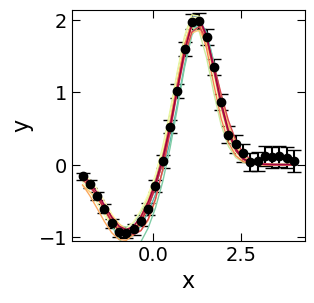

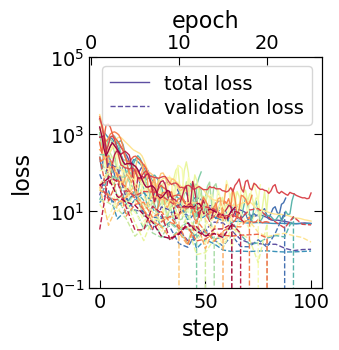

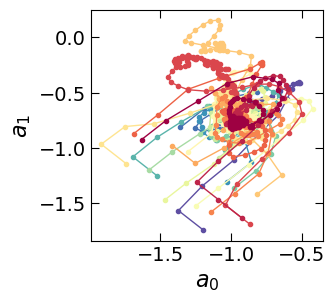

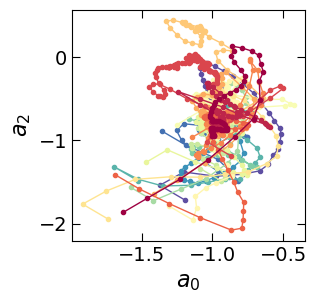

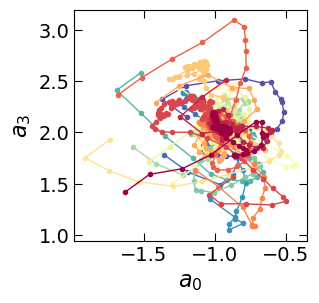

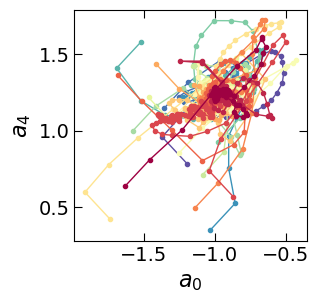

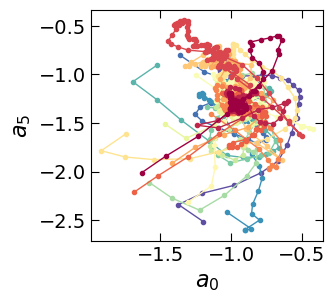

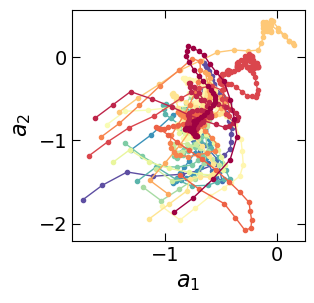

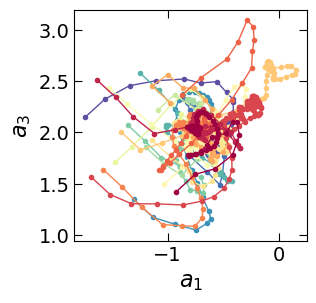

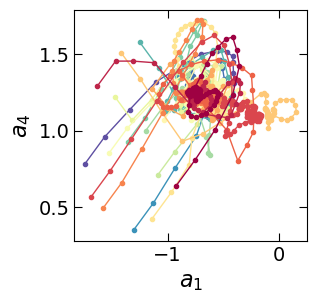

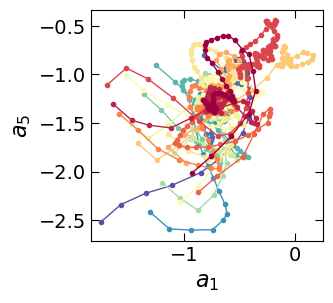

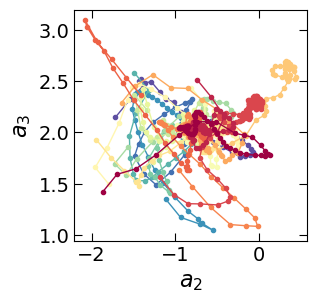

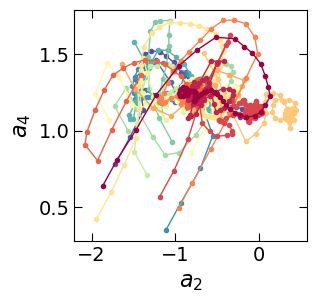

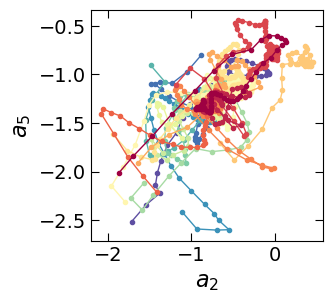

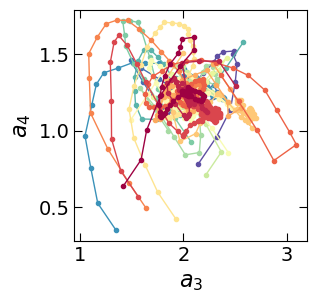

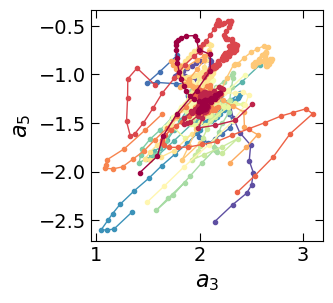

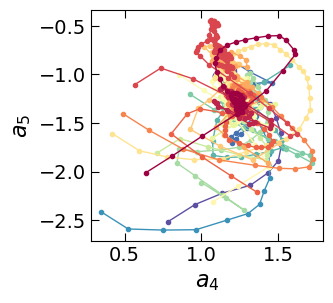

Reading from file: walks/gm2c_lgNmax3.48_narrow_all.txt


In [53]:
walks = mnt.explore()
mnt.visualize(walks)
data = mnt.load()

## Emulation

### GPR

In [54]:
GPR_Exists = Walks_Exist
CV_Thresh = 1e-3 
GPR_Dir = 'gpr/stats_'+id_str
gprt = GPRTrainer(data_file=mnt.walks_file,tmp_dir=GPR_Dir)

In [ ]:
start_time = time()
Kernel = 'rbf' if Model_Type == 'ps' else ('matern' if n_comp == 1 else ('matern' if Narrow else 'matern')) 
Max_Iter = 25 if Model_Type == 'ps' else (25 if n_comp == 1 else 50)
if GPR_Exists:
    interpolator = gprt.train_gpr(verbose=True,vary_kernel=False,kernel=Kernel,skip_train=True)
else:
    interpolator = gprt.train_gpr(cv_thresh=CV_Thresh,verbose=True,vary_kernel=True,max_iter=Max_Iter,max_iter_vary=Max_Iter//5)
gprt.time_this(start_time)


Varying kernels to find best option
Maximum number of iterations reached. GPR may not be properly trained.
Maximum number of iterations reached. GPR may not be properly trained.
Maximum number of iterations reached. GPR may not be properly trained.

Kernel matern is best choice: cv(1pc,99pc) after 10 iters = (-2.26e-01,2.64e-01)


... training with 105 of 2108 samples
... ... current conv_stat = 1.00e+00; waiting for 1.00e-03
... setting up Gaussian Process Regression
... ... using anisotropic Matern kernel with nu = 2.5
... ... starting with (norm,scale) = (1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00)
... ... fitting GP on training set (105 values; ~5% of input data)
0 min 1.61 seconds

... ... setting up Cholesky decomposition
... ... log-marg-like = 223.50
... ... best kernel params = (0.495,0.658,0.856,2.132,0.471,-0.040,1.542)
1.28**2 * Matern(length_scale=[1.93, 2.35, 8.43, 1.6, 0.961, 4.68], nu=2.5)
... ... writing best kernel params to file: gpr/stats

### Neural network

In [ ]:
Xp = data[1:,:]
Yp = mnt.rv(data[0])

Xp.shape,Yp.shape

In [ ]:
# Train = False if Narrow else True
# FileStem = 'net/NN_'+id_str
# Seed = None #if Model_Type == 'ps' else 42

# # N_L = 12+1 # 4,8,12,16,20
# # Delta = 7
# # HLay = [n_params + Delta]*(N_L - 1)
# #########
# # * = narrow, & = full
# N_L = 3 if Narrow else 3 # 2,3*&,4
# Fac = 70 if Narrow else 90 # 30,50,70*,90&,120
# HLay = [Fac*n_params]*(N_L - 1)
# HType = 'tanh' if Narrow else 'tanh' # 'tanh'*&, 'relu'
# Wt_Decay = 0.0 # 0.0*&,0.3
# LRate = 1e-5 if Narrow else 1e-5 # 1e-5*&,1e-4
# Max_Epoch = 100000#0
# Check_After = 300 if Narrow else 100 # 300*,100&? 
# Reg_Fun = 'none' 

# params_setup = {'data_dim':Xp.shape[0],'L':N_L,'n_layer':HLay+[1],'seed':Seed,'standardize':True,
#                 'reg_fun':Reg_Fun,'wt_decay':Wt_Decay,
#                 'atypes':[HType]*(N_L-1)+['lin'],'loss_type':'square','file_stem':FileStem}
# params_train = {'lrate':LRate,'max_epoch':Max_Epoch,'mb_count':int(np.sqrt(0.8*Xp.shape[1])),'check_after':Check_After}
#                 #,'val_frac':Val_Frac}    
# net = Sequential(params_setup)
# if Train:
#     start_time = time()
#     net.train(Xp,Yp,params_train)
#     net.save()
#     print('... trained network with setup params: ',net.params)
#     net.time_this(start_time)
# else:
#     net.load()
#     print('Loaded network with setup params: ',net.params)
# print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))
# print ('... done')

In [ ]:
[3*n_params,n_params**2,2*n_params**2,3*n_params**2]

In [ ]:
Build = False if Model_Type == 'ps' else True

Train_Frac = 0.6 if Model_Type == 'ps' else 0.75
Val_Frac = 0.2
Arch_Type = 'emulator:shallow'
Min_Layer = 3
Max_Layer = 3
Max_Ex = [3*n_params,n_params**2,2*n_params**2] if n_params > 3 else [n_params**2,2*n_params**2]
LRates = [3e-4] # None or list of floats
Wt_Decays = [0.0] # non-empty list
N_Iter = 10 #if Model_Type == 'ps' else 5
TTL = 1e-3
Loss_Type = 'square'
Seed = None
FileStem = 'net/NN_'+id_str

start_time = time()
bnn = BuildNN(Xp,Yp,train_frac=Train_Frac,arch_type=Arch_Type,max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,thresholds=None,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,
              target_test_stat=TTL,loss_type=Loss_Type,seed=Seed,file_stem=FileStem)
if Build:
    net,params_train,mtl = bnn.trainNN()
    print('Best mean test loss = {0:.3e}'.format(mtl))
    print('Setup params: ',net.params)
    print('Training params: ',params_train)
else:
    net = bnn.load()
    print('Loaded network with')
    print('...    setup params: ',net.params)
    params_train = bnn.load_train()
    print('... training params: ',params_train)

print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))
bnn.time_this(start_time)

In [ ]:
if Build:#Train:
    plt.figure(figsize=(4,4))
    plt.xlim(0.5,2*params_train['max_epoch'])
    # plt.ylim(1e-4,1e7)
    plt.yscale('log')
    plt.xscale('log')
    nn_label = '{0:1d}-layer NN'.format(net.L)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(net.epochs,net.epoch_loss,'k-',lw=0.5,label=nn_label+': train')
    plt.plot(net.epochs,net.val_loss,'r-',lw=0.5,label=nn_label+': val')
    plt.legend()
    plt.show()
    print(net.epoch_loss[-1])

### Testing emulators

In [ ]:
print('True loss calculation')
start_time = time()
Nsamp_ev = 3000
Xp_ev = mnt.gen_latin_hypercube(Nsamp=Nsamp_ev,dim=mnt.n_params,param_mins=mnt.param_mins,param_maxs=mnt.param_maxs)
Yp_ev = np.zeros((1,Nsamp_ev))
loss_params_ev = copy.deepcopy(loss_params)
loss_params_ev['Y_full'] = mnt.Y
for n in range(Nsamp_ev):
    # model.params[:,0] = Xp_ev[n]
    model.params[:,0] = Xp_ev[n]
    Loss_ev = mnt.loss_module(loss_params_ev)
    Yp_ev[0,n] = Loss_ev.forward(model.calc_model(mnt.X))
    mnt.status_bar(n,Nsamp_ev)
Xp_ev = Xp_ev.T
mnt.time_this(start_time)

print('NN prediction for loss')
start_time = time()
Yp_ev_pred_nn = net.predict(Xp_ev)
mnt.time_this(start_time)

resid_nn = Yp_ev_pred_nn[0]/Yp_ev[0] - 1

print('GPR prediction for loss')
start_time = time()
Yp_ev_pred_gpr = gprt.predict(Xp_ev.T,interpolator)
mnt.time_this(start_time)

resid_gpr = Yp_ev_pred_gpr/Yp_ev[0] - 1

In [ ]:
plt.xscale('log')
plt.xlabel('true loss')
plt.ylabel('predicted / true - 1')
plt.ylim(-1,1)
plt.scatter(Yp_ev[0],resid_nn,s=0.8,color='r',label='NN')
plt.scatter(Yp_ev[0],resid_gpr,s=0.8,color='b',label='GPR')
plt.legend()
plt.show()

plt.figure(figsize=(5,5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('true loss')
plt.ylabel('predicted loss')
plt.plot(np.logspace(2.0,3.5,10),np.logspace(2.0,3.5,10),'k--',lw=1)
plt.scatter(Yp_ev[0],Yp_ev_pred_nn[0],s=0.8,color='r',label='NN')
plt.scatter(Yp_ev[0],Yp_ev_pred_gpr,s=0.8,color='b',label='GPR')
plt.legend()
plt.show()

## MCMC

In [ ]:
Like_Dir = '../code/likes/'
Plots_Dir = 'plots/'

Run_Cobaya = True #if not Narrow else False
Run_NN = True #if not Narrow else False
Run_GPR = True #if not Narrow else False

Max_Samples = 1000000
Rminus1_Stop = 0.01
Rminus1_CL_Stop = 0.05 # 0.05
Rminus1_CL_Level = 0.95 # 95

Burn_In = 0

if id_str[:2] == 'ps':
    Latex_List = ['a_{0}','a_{1}','a_{2}']
    Params_List = ['a0','a1','a2']
else:
    Latex_List = []
    Params_List = []
    for c in range(n_comp):
        Latex_List.append(['A_{'+str(c+1)+'}','\\mu_{'+str(c+1)+'}','\\ln(\\sigma^{2}_{'+str(c+1)+'})'])
        Params_List.append(['A'+str(c+1),'mu'+str(c+1),'lnsig2'+str(c+1)])
    Latex_List = [item for sublist in Latex_List for item in sublist]
    Params_List = [item for sublist in Params_List for item in sublist]

info = {}
info['params'] = {}
info['likelihood'] = {'likelihoods.Chi2Like':
                      {'python_path':Like_Dir,
                       'X':X_all,'Y':Y_all,'cov_mat':cov_mat}}
if id_str[:2] == 'ps':
    info['theory'] = {'examplelikes.PowSineTheory':
                      {'python_path':Like_Dir,
                       'X':X_all}}
    for p in range(len(Params_List)):
        ref = 0.5*(mnt.param_mins[p] + mnt.param_maxs[p])
        info['params'][Params_List[p]] = {'ref':{'min':ref-0.001,'max':ref+0.001},
                                          'prior':{'min':mnt.param_mins[p],'max':mnt.param_maxs[p]},
                                          'proposal':0.01,'latex':Latex_List[p]}
else:
    info['theory'] = {'examplelikes.GaussMixTheory':
                      {'python_path':Like_Dir,
                       'X':X_all,'n_comp':n_comp}}
    for c in range(n_comp):
        ref = 0.5*(mnt.param_mins[3*c] + mnt.param_maxs[3*c])
        info['params'][Params_List[3*c]] = {'ref':{'min':ref-0.001,'max':ref+0.001},
                                              'prior':{'min':mnt.param_mins[3*c],'max':mnt.param_maxs[3*c]},
                                              'proposal':0.01,'latex':Latex_List[3*c]}
        ref = 0.5*(mnt.param_mins[3*c+1] + mnt.param_maxs[3*c+1])
        info['params'][Params_List[3*c+1]] = {'ref':{'min':ref-0.001,'max':ref+0.001},
                                                  'prior':{'min':mnt.param_mins[3*c+1],'max':mnt.param_maxs[3*c+1]},
                                                  'proposal':0.01,'latex':Latex_List[3*c+1]}
        ref = 0.5*(mnt.param_mins[3*c+2] + mnt.param_maxs[3*c+2])
        info['params'][Params_List[3*c+2]] = {'ref':{'min':ref-0.001,'max':ref+0.001},
                                                  'prior':{'min':mnt.param_mins[3*c+2],'max':mnt.param_maxs[3*c+2]},
                                                  'proposal':0.01,'latex':Latex_List[3*c+2]}

info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 1000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}
info_output = 'stats/chains/'+id_str
info['output'] = info_output
info["force"] = True    

info_nn = copy.deepcopy(info)
info_nn['likelihood'] = {'likelihoods.EmulLike':
                         {'python_path':Like_Dir}}
info_nn['theory'] = {'likelihoods.NNTheory':
                         {'python_path':Like_Dir,
                          'net':net,'keys':Params_List}}
info_nn['output'] = info_output+'_nn'

info_gpr = copy.deepcopy(info)
info_gpr['likelihood'] = {'likelihoods.EmulLike':
                             {'python_path':Like_Dir}}
info_gpr['theory'] = {'likelihoods.GPRTheory':
                         {'python_path':Like_Dir,
                          'gprt':gprt,'interpolator':interpolator,'keys':Params_List}}
info_gpr['output'] = info_output+'_gpr'


In [ ]:
if Run_Cobaya:
    start_time = time()
    updated_info, sampler = run(info)
    Neval_cobaya = pic.calc_Neval(sampler)
    print('Neval_cobaya = {0:d}'.format(Neval_cobaya))
    mnt.time_this(start_time)
else:
    Neval_cobaya = 33149 if Model_Type == 'ps' else 0
    print('Chains (hopefully) exist!')

In [ ]:
if Run_NN:
    start_time = time()
    updated_info_nn, sampler_nn = run(info_nn)
    Neval_nn = pic.calc_Neval(sampler_nn)
    print('Neval_nn = {0:d}'.format(Neval_nn))
    mnt.time_this(start_time)
else:
    print('Chains (hopefully) exist!')

In [ ]:
if Run_GPR:
    start_time = time()
    updated_info_gpr, sampler_gpr = run(info_gpr)
    Neval_gpr = pic.calc_Neval(sampler_gpr)
    print('Neval_gpr = {0:d}'.format(Neval_gpr))
    mnt.time_this(start_time)
else:
    print('Chains (hopefully) exist!')

In [ ]:
Save_Fig = True

Show_MCMC = True
Show_NN = True
Show_GPR = True

In [ ]:
Burn_Frac = 0.3
rng = np.random.RandomState(42)
dim = n_params

start_time = time()

if Show_MCMC:
    gd_sample = loadMCSamples(os.path.abspath(info["output"]),settings={'ignore_rows':Burn_Frac})
    gd_sample.label = 'MCMC: {0:d} evals'.format(Neval_cobaya) 
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]
    sample = gd_sample.samples
    sample = sample.T
    ibest = sample[-2].argmin()
    mcmc_best = sample[:dim,ibest]
    mcmc_chi2 = sample[-2,ibest]
    pval = sysp.gammainc(mcmc_chi2/2,dof/2)
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))
    print('MCMC...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params)+','.join(['%.4e' % (pval,) for pval in mcmc_best])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params)+','.join(['%.4e' % (pval,) for pval in mcmc_sig])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2,dof,mcmc_chi2/dof,pval))

if Show_NN:
    gd_sample_nn = loadMCSamples(os.path.abspath(info_nn["output"]),settings={'ignore_rows':Burn_Frac})
    gd_sample_nn.label = '     NN: {0:d} evals'.format(Xp.shape[1])
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat_nn = gd_sample_nn.getCovMat().matrix[:dim, :dim]
    sample_nn = gd_sample_nn.samples
    sample_nn = sample_nn.T
    ibest_nn = sample_nn[-2].argmin()
    mcmc_best_nn = sample_nn[:dim,ibest_nn]
    mcmc_chi2_nn = sample_nn[-2,ibest_nn]
    pval_nn = sysp.gammainc(mcmc_chi2_nn/2,dof/2)
    mcmc_sig_nn = np.sqrt(np.diag(mcmc_covmat_nn))
    print('NN...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params)+','.join(['%.4e' % (pval,) for pval in mcmc_best_nn])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params)+','.join(['%.4e' % (pval,) for pval in mcmc_sig_nn])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2_nn,dof,mcmc_chi2_nn/dof,pval_nn))

if Show_GPR:
    gd_sample_gpr = loadMCSamples(os.path.abspath(info_gpr["output"]),settings={'ignore_rows':Burn_Frac})
    gd_sample_gpr.label = '   GPR: {0:d} evals'.format(gprt.pred_var.size)
    # samples contain params | chi2 | chi2__name | ?? | ??
    mcmc_covmat_gpr = gd_sample_gpr.getCovMat().matrix[:dim, :dim]
    sample_gpr = gd_sample_gpr.samples
    sample_gpr = sample_gpr.T
    ibest_gpr = sample_gpr[-2].argmin()
    mcmc_best_gpr = sample_gpr[:dim,ibest_gpr]
    mcmc_chi2_gpr = sample_gpr[-2,ibest_gpr]
    pval_gpr = sysp.gammainc(mcmc_chi2_gpr/2,dof/2)
    mcmc_sig_gpr = np.sqrt(np.diag(mcmc_covmat_gpr))
    print('GPR...')
    print("... best fit ( a0,...a{0:d}) = ( ".format(n_params)+','.join(['%.4e' % (pval,) for pval in mcmc_best_gpr])+" )")
    print("... std dev  ( a0,...a{0:d}) = ( ".format(n_params)+','.join(['%.4e' % (pval,) for pval in mcmc_sig_gpr])+" )")
    print("... chi2_best,dof,chi2_red,pval: {0:.3f},{1:d},{2:.3f},{3:.3e}".format(mcmc_chi2_gpr,dof,mcmc_chi2_gpr/dof,pval_gpr))

plot_param_list = Params_List
Subplot_Size = 1.6 

gdplot = gdplt.get_subplot_plotter(subplot_size=Subplot_Size)
gdplot.settings.num_plot_contours = 3
gdplot.settings.axes_fontsize = FS3
gdplot.settings.axes_labelsize = FS2
gdplot.settings.title_limit_fontsize = FS3

show_list = []
fill_list = []
col_list = []
if Show_MCMC:
    show_list.append(gd_sample)
    fill_list.append(True)
    col_list.append('indigo')
if Show_NN:
    show_list.append(gd_sample_nn)
    fill_list.append(True)
    col_list.append('crimson')
if Show_GPR:
    show_list.append(gd_sample_gpr)
    fill_list.append(True)
    col_list.append('darkgreen')
gdplot.triangle_plot(show_list, plot_param_list,filled=fill_list,
                     contour_colors=col_list,legend_loc='upper right',
                     title_limit=0)
for par_y in range(dim):
    str_y = plot_param_list[par_y]
    ax = gdplot.subplots[par_y,par_y]
    if Show_MCMC:
        ax.axvline(mcmc_best[par_y],c='indigo',ls='--',lw=1,alpha=0.6)
    if Show_NN:
        ax.axvline(mcmc_best_nn[par_y],c='crimson',ls='--',lw=1,alpha=0.6)
    if Show_GPR:
        ax.axvline(mcmc_best_gpr[par_y],c='darkgreen',ls='--',lw=1,alpha=0.6)
    for par_x in range(par_y):
        str_x = plot_param_list[par_x]
        #print(par_x,par_y,':',str_x,str_y)
        ax = gdplot.subplots[par_y,par_x]
        if Show_MCMC:
            ax.scatter([mcmc_best[par_x]],[mcmc_best[par_y]],marker='*',s=50,c='aliceblue')
            ax.axvline(mcmc_best[par_x],c='indigo',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best[par_y],c='indigo',ls='--',lw=1.5,alpha=0.6)
        if Show_NN:
            ax.scatter([mcmc_best_nn[par_x]],[mcmc_best_nn[par_y]],marker='*',s=50,c='peachpuff')
            ax.axvline(mcmc_best_nn[par_x],c='crimson',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best_nn[par_y],c='crimson',ls='--',lw=1,alpha=0.6)
        if Show_GPR:
            ax.scatter([mcmc_best_gpr[par_x]],[mcmc_best_gpr[par_y]],marker='*',s=50,c='lightcyan')
            ax.axvline(mcmc_best_gpr[par_x],c='darkgreen',ls='--',lw=1,alpha=0.6)
            ax.axhline(mcmc_best_gpr[par_y],c='darkgreen',ls='--',lw=1,alpha=0.6)

if Save_Fig:
    filename = 'contours_'+id_str+'.png'
    print('Writing to file: '+Plots_Dir+filename)
    gdplot.export(fname=filename,adir=Plots_Dir)

mnt.time_this(start_time)

In [ ]:
start_time = time()
# MCMC
if Show_MCMC:
    model.params = mnt.cv(mcmc_best[:dim])
    model_best = model.forward(mnt.X)[0]
    
    N_Boot_Cobaya = np.min([1000,int(0.2*sample[0].size)])
    Ind = gd_sample.random_single_samples_indices(random_state=42,max_samples=N_Boot_Cobaya)
    N_Boot_Cobaya = Ind.size
    print('N_Boot_Cobaya: ',N_Boot_Cobaya)
    
    model_boot = np.zeros((N_Boot_Cobaya,n_samp),dtype=float)
    
    print('... extracting stats from subsample')
    for b in range(N_Boot_Cobaya):
        params_b = sample[:dim,Ind[b]] 
        model.params = mnt.cv(params_b[:dim])
        model_boot[b] = model.forward(mnt.X)[0]
        mnt.status_bar(b,N_Boot_Cobaya)
    
    model_16pc = np.percentile(model_boot,16,axis=0)
    model_84pc = np.percentile(model_boot,84,axis=0)

    del model_boot
    gc.collect()

# NN
if Show_NN:
    model.params = mnt.cv(mcmc_best_nn[:dim])
    model_best_nn = model.forward(mnt.X)[0]
    
    N_Boot_NN = np.min([1000,int(0.2*sample_nn[0].size)])
    Ind_nn = gd_sample_nn.random_single_samples_indices(random_state=42,max_samples=N_Boot_NN)
    N_Boot_NN = Ind_nn.size
    print('N_Boot_NN: ',N_Boot_NN)
    
    model_boot_nn = np.zeros((N_Boot_NN,n_samp),dtype=float)
    
    print('... extracting stats from subsample')
    for b in range(N_Boot_NN):
        params_b = sample_nn[:dim,Ind_nn[b]] 
        model.params = mnt.cv(params_b[:dim])
        model_boot_nn[b] = model.forward(mnt.X)[0]
        mnt.status_bar(b,N_Boot_NN)
    
    model_16pc_nn = np.percentile(model_boot_nn,16,axis=0)
    model_84pc_nn = np.percentile(model_boot_nn,84,axis=0)

    del model_boot_nn
    gc.collect()

# GPR
if Show_GPR:
    model.params = mnt.cv(mcmc_best_gpr[:dim])
    model_best_gpr = model.forward(mnt.X)[0]
    
    N_Boot_GPR = np.min([1000,int(0.2*sample_gpr[0].size)])
    Ind_gpr = gd_sample_gpr.random_single_samples_indices(random_state=42,max_samples=N_Boot_GPR)
    N_Boot_GPR = Ind_gpr.size
    print('N_Boot_GPR: ',N_Boot_GPR)
    
    model_boot_gpr = np.zeros((N_Boot_GPR,n_samp),dtype=float)
    
    print('... extracting stats from subsample')
    for b in range(N_Boot_GPR):
        params_b = sample_gpr[:dim,Ind_gpr[b]] 
        model.params = mnt.cv(params_b[:dim])
        model_boot_gpr[b] = model.forward(mnt.X)[0]
        mnt.status_bar(b,N_Boot_GPR)
    
    model_16pc_gpr = np.percentile(model_boot_gpr,16,axis=0)
    model_84pc_gpr = np.percentile(model_boot_gpr,84,axis=0)

    del model_boot_gpr
    gc.collect()

cols = ['indigo','crimson','darkgreen']
plt.figure(figsize=(7,7))
plt.xlabel('x')
plt.ylabel('y')
if Model_Type == 'ps':
    plt.ylim(-1,6)
else:
    if n_comp == 1:
        plt.ylim(-1.5,1)
    else:
        plt.ylim(-1.5,3)
if Show_MCMC:
    plt.plot(mnt.X[0],model_best,'-',lw=1,c=cols[0],label='MCMC')
    plt.fill_between(mnt.X[0],model_84pc,model_16pc,color=cols[0],alpha=0.15)
if Show_NN:
    plt.plot(mnt.X[0],model_best_nn,'-',lw=1,c=cols[1],label='NN')
    plt.fill_between(mnt.X[0],model_84pc_nn,model_16pc_nn,color=cols[1],alpha=0.15)
if Show_GPR:
    plt.plot(mnt.X[0],model_best_gpr,'-',lw=1,c=cols[2],label='GPR')
    plt.fill_between(mnt.X[0],model_84pc_gpr,model_16pc_gpr,color=cols[2],alpha=0.15)

plt.errorbar(mnt.X[0],mnt.Y[0],yerr=sigma,c='k',ls='none',capsize=5,marker='o',markersize=4,label='data')

plt.legend(loc='upper left')
plt.minorticks_on()
if Save_Fig:
    filename = Plots_Dir+'stats_'+id_str+'.png'
    print('Writing to file: '+filename)
    plt.savefig(filename,bbox_inches='tight')
plt.show()

mnt.time_this(start_time)